# Google Collab Setup

In [ ]:
# Setup Collab
from google.colab import drive
drive.mount('/content/drive')

# Path to the project on drive
root = "/content/drive/MyDrive/Kaggle-Competition/"


In [ ]:
!pip install torchsummary

# Jupyter Notebook Setup

In [1]:
# Local path to the project
root = "/home/gabriel/Desktop/POLY/PHD/Cours/INF8953CE/Competition/"

# Imports Packages

In [2]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import Preprocessing as pre
from Utils import randomSearch, save_submission

# Import and Process the Data

In [8]:
data_root = root + "Data/"

# Train valid data
X = np.load(data_root + "train_images.npy/train_images.npy", allow_pickle=True, encoding='bytes')
X = np.vstack(X[:, 1]).astype(np.dtype('u1'))

Y = np.genfromtxt(data_root + "train_labels/train_labels.csv", delimiter=',', skip_header=1, dtype='U')[:, 1]
encoder = LabelEncoder()
Y = encoder.fit_transform(Y).astype('u1')

print(encoder.classes_)


['apple' 'empty' 'moustache' 'mouth' 'mug' 'nail' 'nose' 'octagon'
 'paintbrush' 'panda' 'parrot' 'peanut' 'pear' 'pencil' 'penguin' 'pillow'
 'pineapple' 'pool' 'rabbit' 'rhinoceros' 'rifle' 'rollerskates'
 'sailboat' 'scorpion' 'screwdriver' 'shovel' 'sink' 'skateboard' 'skull'
 'spoon' 'squiggle']


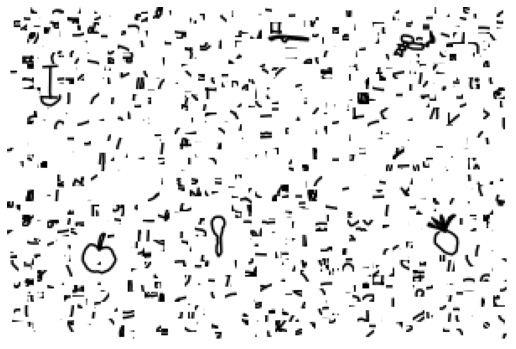

['shovel' 'rifle' 'scorpion' 'apple' 'spoon' 'pineapple']


In [9]:
# Plot 6 different pictures
plt.figure(figsize = (9,9))
pre.plot_digits( X[:6] )
print(encoder.inverse_transform(Y[:6]))

### Data Split

In [10]:
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(X, Y, test_size = 0.1, stratify = Y, random_state = 42)

del X, Y

print(Xtrain.shape)
print(Xvalid.shape)


(9000, 10000)
(1000, 10000)


### Data Augmentation

In [11]:
# Horizontal relections
Xtrain = np.vstack( (Xtrain, pre.reverse_images(Xtrain)) )
Ytrain = np.hstack((Ytrain, Ytrain))
# 4 different translations
Xtrain = np.vstack( (Xtrain, pre.translate_images(Xtrain, [10, -10, 0, 0], [0, 0, 10, -10])) )
Ytrain = np.hstack((Ytrain, Ytrain, Ytrain, Ytrain, Ytrain))
print(Xtrain.shape)
print(Ytrain.shape)


(90000, 10000)
(90000,)


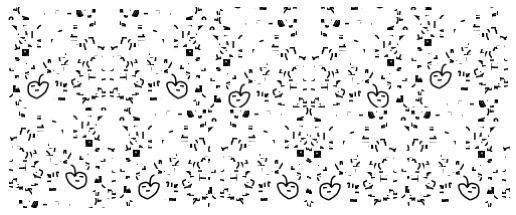

['apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple' 'apple'
 'apple']


In [12]:
# Plot different pictures
plt.figure(figsize = (9,9))
pre.plot_digits( Xtrain[::9000], images_per_row = 5)
print(encoder.inverse_transform(Ytrain[::9000]))


### Data preprocessing

In [13]:
Xtrain = (Xtrain>50).astype(np.dtype('u1'))         # Binarization
Xvalid = (Xvalid>50).astype(np.dtype('u1'))         # Binarization

# Other preprocessing could be experimented with 
# e.g standardization, normalization ...

# Baseline Classifier

In [ ]:
Xtrain = csr_matrix(Xtrain)                        # Sparse storage
Xvalid = csr_matrix(Xvalid)

In [15]:
baselineModel = SGDClassifier(random_state=42)
a_range = np.logspace(-5, -1, 5)
train_score = []
valid_score = []

for a in a_range:
    baselineModel.set_params(alpha = a)
    baselineModel.fit(Xtrain, Ytrain)
    train_score.append(np.mean(baselineModel.predict(Xtrain) == Ytrain))
    valid_score.append(np.mean(baselineModel.predict(Xvalid) == Yvalid))
    print(f"Done with alpha = {a}")


In [15]:
best_alpha_idx = np.argmax(valid_score)
print(f"Best Performance with alpha = {a_range[best_alpha_idx]:e}")
print(f"Training set Accuracy = {100 * train_score[best_alpha_idx]:.2f}%")
print(f"Validation set Accuracy = {100 * valid_score[best_alpha_idx]:.2f}%")


Best Performance with alpha = 1.000000e-01
Training set F1-measure = 26.42%
Validation set F1-measure = 3.24%


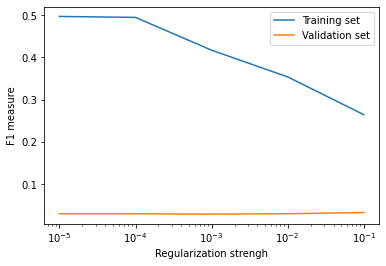

In [16]:
plt.plot(a_range, train_score, label = "Training set")
plt.plot(a_range, valid_score, label = "Validation set")
plt.xlabel("Regularization strengh")
plt.ylabel("F1 measure")
plt.legend()
plt.xscale('log')


# Random Forests

In [ ]:
rfmodel = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [ ]:
hyperparams = {'n_estimators' : [200, 300, 400, 500],
               'max_depth' : [10, 20, 30, 40, 50],
               'min_samples_leaf' : [1, 10, 20]}

# Very broad random hyperparameter search to get a good idea of which values have potential
randomSearch(rfmodel, Xtrain, Ytrain, Xvalid, Yvalid, hyperparams, lambda x, y: np.mean(x == y), n_choices = 30)

In [ ]:
# best one {'n_estimators': 400, 'max_depth': 50, 'min_samples_leaf': 10}

# Manually adjust hyperparams for bias-variance tradeoff
rfmodel.set_params( **{'n_estimators': 400, 'max_depth': 50, 'min_samples_leaf': 10})
rfmodel.fit(Xtrain, Ytrain)
print(f"Training set Accuracy : {100 * np.mean(rfmodel.predict(Xvalid) == Yvalid) : .2f}%")

# Convolutionnal Neural Network (CNN)
### Setup

In [16]:
# Test data
Xtest = np.load(data_root + "test_images.npy/test_images.npy", allow_pickle=True, encoding='bytes')
Xtest = np.vstack(Xtest[:, 1])
Xtest = (Xtest > 50).astype(np.dtype('u1'))

In [17]:
# Reshape the data into 4D tensors
matrix_list   = []
for i in range(0,Xtrain.shape[0]):
    matrix    = [ np.array(Xtrain[i]).reshape(100, 100) ] 
    matrix_list.append(matrix)
Xtrain   = np.array(matrix_list)

matrix_list   = []
for i in range(0,Xvalid.shape[0]):
    matrix    = [ np.array(Xvalid[i]).reshape(100, 100) ] 
    matrix_list.append(matrix)
Xvalid    = np.array(matrix_list)

matrix_list   = []
for i in range(0,Xtest.shape[0]):
    matrix    = [ np.array(Xtest[i]).reshape(100, 100) ] 
    matrix_list.append(matrix)
Xtest    = np.array(matrix_list)

del matrix, matrix_list

print(Xtrain.shape)
print(Xvalid.shape)
print(Xtest.shape)

(90000, 1, 100, 100)
(1000, 1, 100, 100)
(10000, 1, 100, 100)


In [18]:
# Checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
print("Found:",torch.cuda.device_count(), device)

Found: 0 cpu


In [20]:
class CNN_1(nn.Module):
    """Medium sized network """    
    def __init__(self, map = 7):
        fc_output_size  = 500
        map_size        = map   #(3,7,11,15,19,...)
        block1_features = 50
        block2_features = 100
        drop_out        = 0.8
        pad_size        = 1   #(don't touch)
        
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(1, block1_features, map_size, padding=1)
        fc_input_size = 100 -map_size +1 +2*pad_size
        self.bn1   = nn.BatchNorm2d(block1_features)
        self.conv2 = nn.Conv2d(block1_features, block1_features, map_size, padding=1)
        fc_input_size += (-map_size +1 +2*pad_size)
        self.bn2   = nn.BatchNorm2d(block1_features)        

        fc_input_size /= 2
        
        # conv block 2
        self.conv3 = nn.Conv2d(block1_features, block2_features, map_size, padding=1)
        fc_input_size += (-map_size +1 +2*pad_size)
        self.bn3   = nn.BatchNorm2d(block2_features)
        self.conv4 = nn.Conv2d(block2_features, block2_features, map_size, padding=1)
        fc_input_size += (-map_size +1 +2*pad_size)
        self.bn4   = nn.BatchNorm2d(block2_features)        

        fc_input_size /= 2
        
        # fully connected layers
        self.fc1     = nn.Linear(block2_features*int(fc_input_size)**2, fc_output_size)
        self.bn5     = nn.BatchNorm1d(fc_output_size)
        self.dropout = nn.Dropout(drop_out)
        self.fc2     = nn.Linear(fc_output_size, 31)        

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)       
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)        
        x = x.view(x.size(0), -1)       
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)        

        return x

In [ ]:
class CNN_2(nn.Module):
    """Medium sized network """    
    def __init__(self):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(1, 50, 5, padding=1)
        self.bn1   = nn.BatchNorm2d(50)
        self.conv2 = nn.Conv2d(50, 50, 5, padding=1)
        self.bn2   = nn.BatchNorm2d(50)        
        # conv block 2
        self.conv3 = nn.Conv2d(50, 100, 5, padding=1)
        self.bn3   = nn.BatchNorm2d(100)
        self.conv4 = nn.Conv2d(100, 100, 5, padding=1)
        self.bn4   = nn.BatchNorm2d(100)        
        # fully connected layers
        self.fc1     = nn.Linear(100*22*22, 500)
        self.bn5     = nn.BatchNorm1d(500)
        self.dropout = nn.Dropout(0.98)
        self.fc2     = nn.Linear(500, 31)        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)        
        x = x.view(x.size(0), -1)        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)        
        return x

In [ ]:
model = CNN_1().to(device)
print(model)
summary(model, (1, 100, 100))

In [ ]:
def train(model, optimizer, batch_size, epoch):
    """Perform one epoch of training."""
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    correct   = 0
    test_size = 0
    for i in range(0, len(Xtrain), batch_size):
        inputs = torch.tensor(Xtrain[i:i + batch_size], dtype = torch.float32).to(device)
        target = torch.tensor(Ytrain[i:i + batch_size], dtype = torch.int64).to(device)
        batch_idx = int( i / batch_size ) + 1
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch + 1} [{batch_idx * len(inputs)}/{len(Xtrain)}]")

In [ ]:
def test(model, batch_size):
    """Evaluate the model by doing one pass over all batches of data"""
    model.eval()
    with torch.no_grad():
        train_good = 0
        train_size = 0
        # Forward propagate on training set
        for i in range(0, len(Xtrain), batch_size):
            inputs = torch.tensor(Xtrain[i:i + batch_size], dtype=torch.float32).to(device)
            target = torch.tensor(Ytrain[i:i + batch_size], dtype=torch.int64).to(device)            
            output = model(inputs)
            train_size += len(inputs)
            pred = output.argmax(1)
            train_good += pred.eq(target).sum().item()                
        valid_good = 0
        valid_size = 0
        # Forward propagate on validation set
        for i in range(0, len(Xvalid), batch_size):
            inputs = torch.tensor(Xvalid[i:i + batch_size], dtype=torch.float32).to(device)
            target = torch.tensor(Yvalid[i:i + batch_size], dtype=torch.int64).to(device)            
            output = model(inputs)
            valid_size += len(inputs)
            pred = output.argmax(1)
            valid_good += pred.eq(target).sum().item()        
                            
    print(f"\nTrain Accuracy: {train_good}/{train_size} ({100 * train_good/train_size :.2f}%)")
    print(f"Valid Accuracy: {valid_good}/{train_size} ({100 * valid_good/valid_size:.2f}%)")

    # return validation accuracy
    return 100 * valid_good / valid_size

In [ ]:
def labels(X, batch_size):
    """Obtain labels on X by iterating over all batches"""
    model.eval()
    test_labels = []
    with torch.no_grad():
        for i in range(0,len(X), batch_size):
            inputs = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)        
            output = model(inputs)
            pred = output.argmax(1)
            predictions = pred.to("cpu").numpy()
            test_labels = test_labels + list(predictions)
    return test_labels

### Training

In [ ]:

batch_size   = 50
lr           = 1e-3
weight_decay = 0.
optimizer    = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

previous_accuracy = 50
for epoch in range(0, 20):
    train(model, optimizer, batch_size, epoch)
    accuracy = test(model, batch_size)
    if accuracy > previous_accuracy: 
        previous_accuracy = accuracy
        save_submission(root, encoder.inverse_transform( labels(Xtest, batch_size) ))
    print(f"(best accuracy so far: {previous_accuracy: .2f} %\n")     